In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast, AutoTokenizer 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight
import umap
import umap.plot
import gensim
from datetime import datetime, timedelta
import pickle as pkl

# specify GPU
device = torch.device("cuda")

In [2]:
import matplotlib.pyplot as plt

In [3]:
csv_path = 'C:\\Users\\AlexGolden\\Dropbox (BOSTON UNIVERSITY)\\twitter_stocks_project\\Tweets_CSVs\\'
df = pd.read_csv(csv_path+'BLK'+'tweets.csv', parse_dates=['created_at']).dropna()

In [4]:
# split train dataset into train, validation and test sets
train_text, val_text, train_labels, val_labels = train_test_split(df['text'], df['slope_labels'].astype(np.int64), 
                                                                    random_state=2018, 
                                                                    test_size=0.1, 
                                                                    stratify=df['slope_labels'])


In [5]:
train_labels.to_numpy()

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [6]:
def tag_titles(titles):
    for i, title in enumerate(titles):
        toks = gensim.utils.simple_preprocess(title)
        doc = gensim.models.doc2vec.TaggedDocument(toks, [i])
        yield doc

In [7]:
train_title_docs = list(tag_titles(train_text))
val_title_docs = list(tag_titles(val_text))

In [8]:
vecsize = 300
doc_vec_model = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=2, epochs=10)

In [9]:
doc_vec_model.build_vocab(train_title_docs)

In [10]:
doc_vec_model.train(train_title_docs, total_examples=doc_vec_model.corpus_count, epochs=doc_vec_model.epochs)

In [11]:
with open('doc_vectorizer.pkl','rb') as f:
    doc_vec_model = pkl.load(f)
    f.close()

In [12]:
train_vectors = np.zeros((len(train_title_docs),vecsize))
val_vectors = np.zeros((len(val_title_docs),vecsize))

In [13]:
for i,doc in enumerate(train_title_docs):
    train_vectors[i,:] = doc_vec_model.infer_vector(doc.words)

for i,doc in enumerate(val_title_docs):
    val_vectors[i,:] = doc_vec_model.infer_vector(doc.words)

<AxesSubplot:>

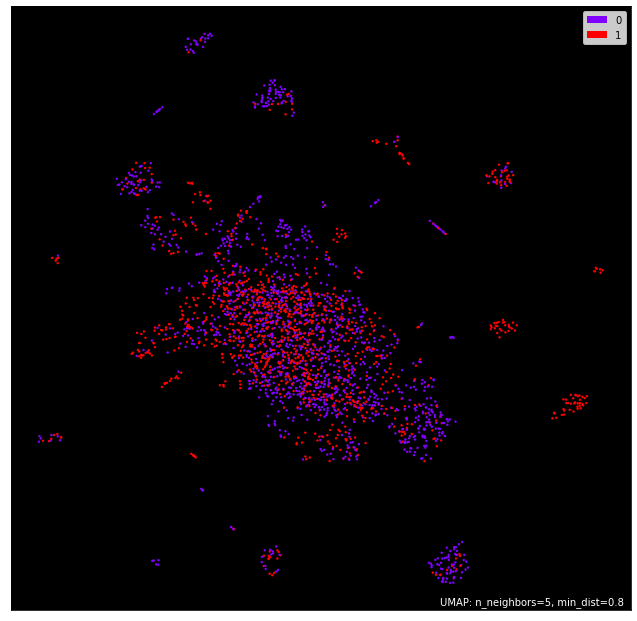

In [14]:
mapper = umap.UMAP(min_dist=0.8, n_neighbors=5, output_metric='euclidean').fit(train_vectors)
umap.plot.points(mapper, labels=train_labels.to_numpy(), theme='fire')

In [66]:
train_vectors = np.zeros((len(train_title_docs),vecsize))
val_vectors = np.zeros((len(val_title_docs),vecsize))

In [67]:
for i,doc in enumerate(train_title_docs):
    train_vectors[i,:] = doc_vec_model.infer_vector(doc.words)

for i,doc in enumerate(val_title_docs):
    val_vectors[i,:] = doc_vec_model.infer_vector(doc.words)

In [68]:
train_ten = torch.tensor(train_vectors,dtype = torch.float)
train_y = torch.tensor(train_labels.tolist())

val_ten = torch.tensor(val_vectors,dtype = torch.float)
val_y = torch.tensor(val_labels.tolist())

In [69]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_ten, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


# wrap tensors
val_data = TensorDataset(val_ten, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [77]:
# bert model
class classifier(nn.Module):

    def __init__(self, insize, num_cats,hidden_layers = 3,width = 512):
        super(classifier, self).__init__()
        self.num_cats = num_cats
        self.insize = insize
        self.h_width = width
        # dropout layer
        self.dropout = nn.Dropout(0.1)
        # relu activation function
        self.relu =  nn.ReLU()
        # dense 1
        self.dense1 = nn.Linear(self.insize,self.h_width)
        # hidden units
        layers = []
        for i in range(hidden_layers):
            layers.append(nn.Linear(self.h_width,self.h_width))
            layers.append(nn.ReLU())
            layers.append(self.dropout)
            
        self.hidden = nn.Sequential(*layers)
        
        self.out = nn.Linear(self.h_width,self.num_cats)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, x):

        # layer 1
        x = self.relu(self.dense1(x))
        x = self.dropout(x)

        # hidden layers
        x = self.hidden(x)
        # output layer
        x = self.out(x)
        
        x = self.softmax(x)

        return x

In [78]:
title_class = classifier(vecsize,2,hidden_layers = 1,width = 32)
title_class = title_class.to(device)

In [79]:
lr = 5e-5
# optimizer
optimizer = AdamW(title_class.parameters(),lr = lr)

In [80]:
# imbalanced data: compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_y.numpy()), train_y.numpy())

print("Class Weights:",class_weights)

# weights to tensor
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)

# loss
cross_entropy  = nn.NLLLoss(weight=weights) 
cross_entropy  = nn.NLLLoss()

# number of training epochs
epochs = 500

Class Weights: [0.93828017 1.07041139]


In [81]:
# function to train the model for an epoch
def train_classifier():
    title_class.train()
    total_loss, total_accuracy = 0, 0

    # save predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
        # print every 50 batches
        if step % 500 == 0 and not step == 0:
            # print('Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
            pass
        batch = [r.to(device) for r in batch]
        y, labels = batch
        title_class.zero_grad()        
        
        # get preds
        preds = title_class(y)
        loss = cross_entropy(preds, labels)

        total_loss = total_loss + loss.item()
        loss.backward()

        # clip the the gradients to 1.0
        torch.nn.utils.clip_grad_norm_(title_class.parameters(), 1.0)

        optimizer.step()

        preds=preds.detach().cpu().numpy()

        total_preds.append(preds)

    # compute avg loss
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [82]:
# function for evaluating the model
def evaluate_classifier():
  
    # print("\nEvaluating...")
    title_class.eval()

    total_loss, total_accuracy = 0, 0

    # save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 500 == 0 and not step == 0:

            # report elapsed time & progress
            pass

            # print('Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        batch = [t.to(device) for t in batch]
        y, labels = batch

        with torch.no_grad():
            preds = title_class(y)

            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [83]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
start_time = datetime.now()
#for each epoch
for epoch in range(epochs):
    if (epoch % 50) == 0:
        print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train_classifier()

    #evaluate model
    valid_loss, _ = evaluate_classifier()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(title_class.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

        #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(title_class.state_dict(), 'saved_weights.pt')
    
    if (epoch % 50) == 0:
        print(str(datetime.now() - start_time))
        print(f'\nTraining Loss: {train_loss:.3f}')
        print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 500
0:00:00.233935

Training Loss: 0.691
Validation Loss: 0.692

 Epoch 51 / 500
0:00:11.415087

Training Loss: 0.588
Validation Loss: 0.595

 Epoch 101 / 500
0:00:22.447151

Training Loss: 0.529
Validation Loss: 0.586

 Epoch 151 / 500
0:00:33.314690

Training Loss: 0.473
Validation Loss: 0.594

 Epoch 201 / 500
0:00:44.215046

Training Loss: 0.430
Validation Loss: 0.610

 Epoch 251 / 500
0:00:55.091262

Training Loss: 0.378
Validation Loss: 0.641

 Epoch 301 / 500
0:01:06.016958

Training Loss: 0.346
Validation Loss: 0.680

 Epoch 351 / 500
0:01:16.946155

Training Loss: 0.312
Validation Loss: 0.735

 Epoch 401 / 500
0:01:27.878516

Training Loss: 0.275
Validation Loss: 0.797

 Epoch 451 / 500
0:01:38.794744

Training Loss: 0.241
Validation Loss: 0.854


<AxesSubplot:>

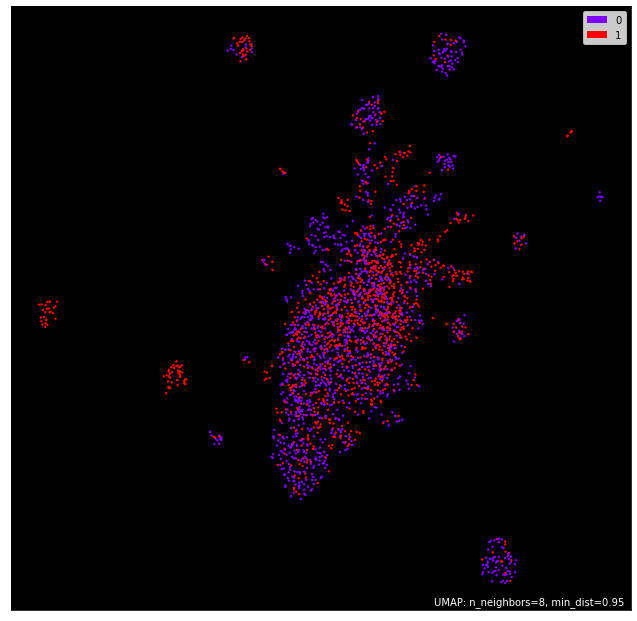

In [84]:
mapper = umap.UMAP(min_dist=0.95, n_neighbors=8, output_metric='euclidean').fit(train_vectors)
umap.plot.points(mapper, labels=train_labels.to_numpy(), theme='fire')

In [85]:
model_path = 'saved_weights.pt'
title_class.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [86]:
guesses = np.zeros_like(train_labels.to_numpy(),dtype = np.float32)
for i,vec in enumerate(train_vectors):
    
    ten = torch.Tensor(vec.reshape(-1,1).T).to(device)
    # get preds
    title_class.zero_grad()
    preds = title_class(ten).detach().cpu().numpy()
    guesses[i] = np.exp(preds[:,1])

In [87]:
preds

array([[-0.7221073, -0.6650023]], dtype=float32)

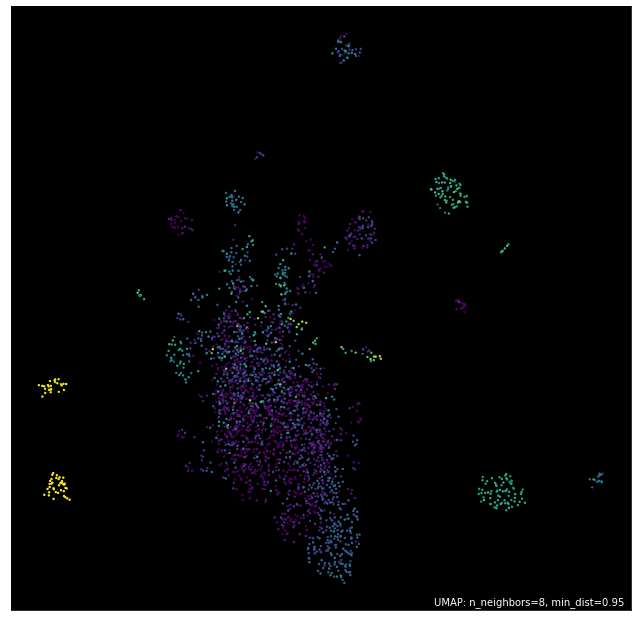

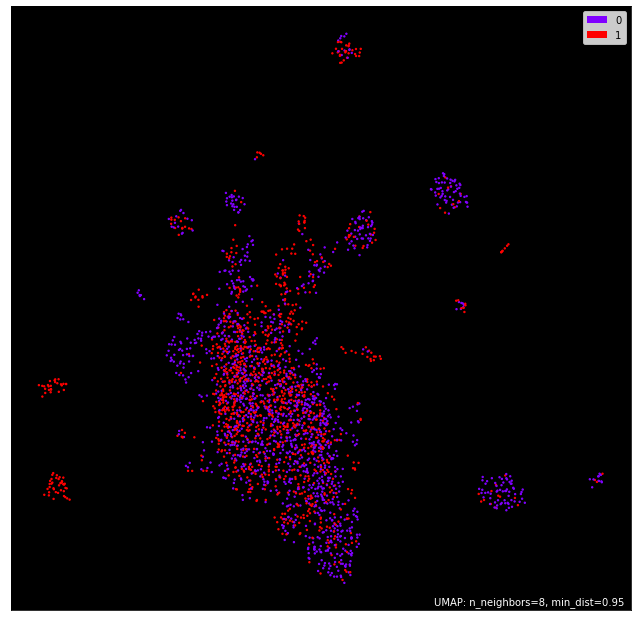

In [88]:
mapper = umap.UMAP(min_dist=0.95, n_neighbors=8, output_metric='euclidean').fit(train_vectors)
umap.plot.points(mapper, values=0.25-(1-guesses)*guesses, theme='viridis')
plt.savefig('BLK_confidence.png')
plt.show()
umap.plot.points(mapper, labels=train_labels.to_numpy(), theme='fire')
plt.savefig('BLK_labels.png')
plt.show()